# Resptive and complete analysis of SCCAF-D framework

### Running SCCAF-D requires the relevant python and R environments, you can refer to readme to install the corresponding packages

In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
from SCCAF import *
import os
import urllib.request

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## The analysis of scanpy

In [2]:
pwd

'/home/feng_shuo/deconvolution'

In [3]:
os.chdir('./SCCAF-D-test/')

In [4]:
ad=sc.read_h5ad('./integrated_baron.h5')

In [5]:
ad.layers['counts']=ad.X.copy()

In [6]:
sc.pp.normalize_total(ad,target_sum=1e4)
sc.pp.log1p(ad)
ad.raw=ad

In [7]:
sc.pp.highly_variable_genes(
    ad,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="sampleID",
    subset=False

    
    
)

In [8]:
ad.var['highly_variable'].sum()

2000

In [9]:
sc.tl.pca(ad, svd_solver='arpack', use_highly_variable=True)

In [10]:
sc.external.pp.harmony_integrate(ad, key='sampleID', basis='X_pca', adjusted_basis='X_pca_harmony',max_iter_harmony=30)

2024-09-02 00:09:02,950 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-02 00:09:22,466 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-02 00:09:22,580 - harmonypy - INFO - Iteration 1 of 30
2024-09-02 00:09:31,217 - harmonypy - INFO - Iteration 2 of 30
2024-09-02 00:09:43,328 - harmonypy - INFO - Iteration 3 of 30
2024-09-02 00:09:53,121 - harmonypy - INFO - Iteration 4 of 30
2024-09-02 00:10:03,632 - harmonypy - INFO - Iteration 5 of 30
2024-09-02 00:10:13,416 - harmonypy - INFO - Iteration 6 of 30
2024-09-02 00:10:17,306 - harmonypy - INFO - Converged after 6 iterations


## Use SCCAF to choose cells

Mean CV accuracy: 0.9933
Accuracy on the training set: 0.9985
Accuracy on the hold-out set: 0.9968


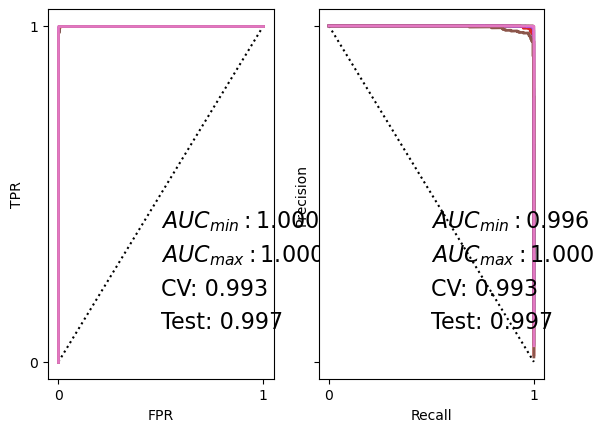

In [11]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.obsm['X_pca_harmony'], ad.obs['cellType'],n=500)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

### Use other iterm in obsm

In [ ]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.obsm['X_'], ad.obs['cellType'],n=500)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

### Use the ad.X

In [ ]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(ad.X, ad.obs['cellType'],n=500)
aucs = plot_roc(y_prob, y_test, clf, cvsm=cvsm, acc=acc)
plt.show()

In [12]:
prob=pd.DataFrame(y_prob,columns=clf.classes_)
pred=pd.DataFrame(y_pred,columns=['predict'])
sccaf=pd.concat([pred,prob],axis=1)

In [13]:
sccaf

,predict,acinar,alpha,beta,delta,duct,gamma,stellate
0,alpha,0.002524,0.993048,0.000956,0.000412,0.001195,0.000562,0.001305
1,duct,0.023060,0.002835,0.000494,0.002461,0.967943,0.000022,0.003184
2,alpha,0.000319,0.990186,0.001648,0.000405,0.000129,0.006003,0.001312
3,alpha,0.000671,0.992968,0.000064,0.000223,0.000473,0.004698,0.000902
4,alpha,0.000170,0.983094,0.009720,0.001533,0.003911,0.001073,0.000499
...,...,...,...,...,...,...,...,...
29087,alpha,0.000163,0.998157,0.000230,0.000238,0.000680,0.000202,0.000330
29088,gamma,0.000010,0.000004,0.000048,0.000027,0.000384,0.999263,0.000264
29089,alpha,0.000148,0.998264,0.000213,0.000074,0.000732,0.000416,0.000153
29090,alpha,0.000347,0.997513,0.000338,0.000476,0.000324,0.000486,0.000515


## Get the optimise cells

In [14]:
sccaf.to_csv('./sccaf-result.csv')
y_test.to_csv('./y_test-result.csv')

In [15]:
y_test

AAACCTGAGAATCTCC-9-6    alpha
AAACCTGAGAGGACGG-6-6     duct
AAACCTGAGCCATCGC-1-6    alpha
AAACCTGAGCTGAAAT-1-6    alpha
AAACCTGAGCTGCAAG-9-6    alpha
                        ...  
HP1526901T2D_I16-2      alpha
HP1526901T2D_F7-2       gamma
HP1525301T2D_K3-2       alpha
HP1526901T2D_N8-2       alpha
HP1526901T2D_A8-2       alpha
Name: cellType, Length: 29092, dtype: category
Categories (7, object): ['acinar', 'alpha', 'beta', 'delta', 'duct', 'gamma', 'stellate']

# Get the optimised reference in R

In [1]:
setwd('./SCCAF-D-test/')

In [2]:
data <- read.csv('./sccaf-result.csv')
test <- read.csv('./y_test-result.csv')

In [3]:
data

X,predict,acinar,alpha,beta,delta,duct,gamma,stellate
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,alpha,2.523625e-03,9.930476e-01,9.557116e-04,4.116669e-04,1.195134e-03,5.615644e-04,1.304728e-03
1,duct,2.305970e-02,2.835409e-03,4.942601e-04,2.461061e-03,9.679434e-01,2.206803e-05,3.184093e-03
2,alpha,3.185584e-04,9.901859e-01,1.647774e-03,4.048915e-04,1.285959e-04,6.002691e-03,1.311558e-03
3,alpha,6.708328e-04,9.929678e-01,6.445491e-05,2.229686e-04,4.734551e-04,4.698264e-03,9.022457e-04
4,alpha,1.702901e-04,9.830942e-01,9.719752e-03,1.533001e-03,3.910589e-03,1.073420e-03,4.987844e-04
5,beta,3.701693e-04,3.744820e-05,9.989130e-01,3.762119e-04,1.827715e-05,2.135052e-04,7.135931e-05
6,alpha,2.001694e-04,9.730731e-01,3.073920e-03,8.243625e-04,1.808154e-02,1.532124e-03,3.214812e-03
7,beta,7.066203e-04,9.665642e-04,9.945378e-01,2.240554e-03,3.442729e-04,4.523838e-04,7.517654e-04
8,alpha,3.978360e-04,9.807133e-01,8.931585e-04,5.225677e-04,3.691214e-03,1.070129e-02,3.080590e-03


In [4]:
test

X,cellType
<chr>,<chr>
AAACCTGAGAATCTCC-9-6,alpha
AAACCTGAGAGGACGG-6-6,duct
AAACCTGAGCCATCGC-1-6,alpha
AAACCTGAGCTGAAAT-1-6,alpha
AAACCTGAGCTGCAAG-9-6,alpha
AAACCTGAGGGAACGG-3-6,beta
AAACCTGAGGTACTCT-7-6,alpha
AAACCTGAGGTGACCA-2-6,beta
AAACCTGAGTCACGCC-9-6,alpha


In [6]:
data <- read.csv('./sccaf-result.csv')
test <- read.csv('./y_test-result.csv')
data <- data[,-1]
sccaf <- cbind(test,data)
rownames(sccaf) <- sccaf[,1]
sccaf <- sccaf[,-1]
index <- sccaf$cellType==sccaf$predict
sccaf_index <- sccaf[index,]
library(dplyr)
mydata <- data.frame(matrix(ncol=2,nrow=0))
for(i in 3:ncol(sccaf_index)){
    name <- arrange(sccaf_index,desc(sccaf_index[,i]))
    name <- name[c(1:100),]
    name <- name[,c(1,i)]
    colnames(name) <- c('celltype','score')
    mydata <- rbind(mydata,name)
}  
X2=sceasy::convertFormat('./integrated_baron.h5',from='anndata',to='seurat')
X2=X2[,rownames(mydata)]
saveRDS(X2,'./integrated_baron_opt.rds')

X -> counts



# Deoconvolution

In [14]:
source("../SCCAF-D/benchmark1.R")
source("../SCCAF-D/deconvolution1.R")
source("../../Rscript/framework1.R")
source("../SCCAF-D/DWLS.R")
setwd("/home/feng_shuo/deconvolution/SCCAF-D-test/")
df <- c('integrated_baron_opt.rds')
bulk_methods =c('nnls','FARDEEP','EpiDISH','RLR')
sc_methods = c("DWLS")
deconvolution = c(sc_methods)
transformation <- 'none'
norm <- 'TMM'
NormTrans <- 'T'
files=c()
for (i in 1:length(df)){
  files[i] <- strsplit(df[i],split = "\\.")[[1]][1]
}
 for (method in deconvolution) {
        if (method %in% sc_methods) {
            deconv_type <- 'sc'
            norm2 <- norm
        } else {
            deconv_type <- 'bulk'
            norm2 <- 'all'
        }
        for (i in 1:length(df)) {
            path <- paste(getwd(), "/DWLS_", files[i], sep = "")
            setwd("/home/feng_shuo/deconvolution/SCCAF-D-test/")
            param_bulkreal <- c("pseudobulk_Baron_T.rds",df[i], transformation, deconv_type, norm, norm2, method, 10000,"none", 1, NormTrans)
            print(param_bulkreal)
            #
            tryCatch({
                results <- bulk_reference(param_bulkreal)
                setwd("/home/feng_shuo/deconvolution/SCCAF-D-test/")
                saveRDS(results, paste0(files[i], "_", method, "_2024-8-8", "_pancreas_cross", ".rds"))
            }, error = function(e) {
                cat("Error with df[", i, "] and method ", method, ": ", conditionMessage(e), "\n")
            })
    }
}

 [1] "pseudobulk_Baron_T.rds"   "integrated_baron_opt.rds"
 [3] "none"                     "sc"                      
 [5] "TMM"                      "TMM"                     
 [7] "DWLS"                     "10000"                   
 [9] "none"                     "1"                       
[11] "T"                       
[1] "number of intersect features: 14346"


Repeated column names found in count matrix

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 3446 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 3727 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 1579 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 2105 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 2877 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 3962 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 3508 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


  acinar    alpha     beta    delta     duct    gamma stellate 
 0.24454  0.17253  0.32219  0.07073  0.07782  0.02146  0.09072 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.24280  0.17208  0.31665  0.07075  0.07863  0.02293  0.09616 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.24747  0.17143  0.32129  0.06586  0.08359  0.02164  0.08873 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.25148  0.17135  0.31428  0.06816  0.07705  0.02157  0.09610 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.23843  0.17077  0.31393  0.07202  0.07869  0.02052  0.10564 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.23815  0.17549  0.31902  0.07261  0.08224  0.02246  0.09002 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.28523  0.18599  0.30964  0.09675  0.04043  0.02121  0.06075 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.24112  0.17268  0.32538  0.07387  0.0

Warning message in data.table::melt(RESULTS):
“data.table 中的 melt 泛型函数被传递了 matrix 即将转向到 reshape2 中的相关方法；请注意 reshape2 已经弃用，这个转向也已经弃用。如果要在 data.table 和 reshape2 同时附着的情况下继续使用 reshape2 中的 melt 方法，（例如 melt.list），你可以把命名空间写在函数名称前面，例如 reshape2::melt(RESULTS)。在下一个版本中，此警告将变成为错误。”
Warning message in data.table::melt(P, id.vars = "CT"):
“data.table 中的 melt 泛型函数被传递了 data.frame 即将转向到 reshape2 中的相关方法；请注意 reshape2 已经弃用，这个转向也已经弃用。如果要在 data.table 和 reshape2 同时附着的情况下继续使用 reshape2 中的 melt 方法，（例如 melt.list），你可以把命名空间写在函数名称前面，例如 reshape2::melt(P)。在下一个版本中，此警告将变成为错误。”


# Use the framework

In [ ]:
#set the path 

In [17]:
setwd('/home/feng_shuo/deconvolution/SCCAF-D-test/')

In [18]:
source('/home/feng_shuo/deconvolution/SCCAF-D/SCCAF_D.R')
path = paste(getwd(), "/sccaf-d-results", sep = "") #the file to save the results of signature matrix
param=c("pseudobulk_Baron_T.rds",'integrated_baron.rds',"none","sc","TMM","TMM",'DWLS',10000,"none",1,'T')
results <- SCCAF_D(param,python_home='/home/feng_shuo/miniconda3/envs/sccaf/bin/python')
saveRDS(results,'./pseudobulk_Baron_integrated_baron_sccaf.rds')

Warning message in .regularise_df(obj@meta.data, drop_single_values = drop_single_values):
“Dropping single category variables:title, source.name, organism, tissue, molecule, processed.data.file, raw.file, donor.id, condition, age, ethnicity, gender, cell.type, Sample, Celltype, barcode, assigned_cluster, lib, donor, predicted_doublet”


< table of extent 0 >
[1] "number of intersect features: 14346"


Repeated column names found in count matrix

Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 3446 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 3727 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 1579 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 2105 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 2877 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 3962 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Using  as id variables

No dimnames in `exprsArray`, assuming `fData` and `cData` are sorted according to `exprsArray`

Assuming data assay in position 1, with name Et is log-transformed.


Done!



Fitted zlm on 3508 genes and 700 cells.
 Using BayesGLMlike ~ Population 


Combining coefficients and standard errors

Calculating log-fold changes

Refitting on reduced model...


Done!

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


  acinar    alpha     beta    delta     duct    gamma stellate 
 0.24454  0.17253  0.32219  0.07073  0.07782  0.02146  0.09072 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.24280  0.17208  0.31665  0.07075  0.07863  0.02293  0.09616 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.24747  0.17143  0.32129  0.06586  0.08359  0.02164  0.08873 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.25148  0.17135  0.31428  0.06816  0.07705  0.02157  0.09610 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.23843  0.17077  0.31393  0.07202  0.07869  0.02052  0.10564 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.23815  0.17549  0.31902  0.07261  0.08224  0.02246  0.09002 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.28523  0.18599  0.30964  0.09675  0.04043  0.02121  0.06075 
  acinar    alpha     beta    delta     duct    gamma stellate 
 0.24112  0.17268  0.32538  0.07387  0.0

Warning message in data.table::melt(RESULTS):
“data.table 中的 melt 泛型函数被传递了 matrix 即将转向到 reshape2 中的相关方法；请注意 reshape2 已经弃用，这个转向也已经弃用。如果要在 data.table 和 reshape2 同时附着的情况下继续使用 reshape2 中的 melt 方法，（例如 melt.list），你可以把命名空间写在函数名称前面，例如 reshape2::melt(RESULTS)。在下一个版本中，此警告将变成为错误。”
Warning message in data.table::melt(P, id.vars = "CT"):
“data.table 中的 melt 泛型函数被传递了 data.frame 即将转向到 reshape2 中的相关方法；请注意 reshape2 已经弃用，这个转向也已经弃用。如果要在 data.table 和 reshape2 同时附着的情况下继续使用 reshape2 中的 melt 方法，（例如 melt.list），你可以把命名空间写在函数名称前面，例如 reshape2::melt(P)。在下一个版本中，此警告将变成为错误。”


In [3]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/feng_shuo/miniconda3/envs/deconvolution/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=zh_CN.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=zh_CN.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=zh_CN.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] MAST_1.26.0                 SingleCellExperiment_1.22.0
 [3] SummarizedExperiment_1.30.2 GenomicRanges_1.52.0       
 [5] GenomeInfoDb_1.36.1         IRanges_2.34.1             
 [7] S4Vectors